In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

print("Loading data...")
df = pd.read_csv('RAW_recipes.csv')

# Drop rows with missing values
df = df.dropna(subset=['name', 'ingredients'])



Loading data...


In [2]:
# Load interactions data
interactions = pd.read_csv("RAW_interactions.csv")

print(interactions.head())
print(interactions.columns)


   user_id  recipe_id        date  rating  \
0    38094      40893  2003-02-17       4   
1  1293707      40893  2011-12-21       5   
2     8937      44394  2002-12-01       4   
3   126440      85009  2010-02-27       5   
4    57222      85009  2011-10-01       5   

                                              review  
0  Great with a salad. Cooked on top of stove for...  
1  So simple, so delicious! Great for chilly fall...  
2  This worked very well and is EASY.  I used not...  
3  I made the Mexican topping and took it to bunk...  
4  Made the cheddar bacon topping, adding a sprin...  
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')


In [3]:
# Aggregate interaction-level data per recipe
recipe_stats = interactions.groupby("recipe_id").agg(
    avg_rating=("rating", "mean"),
    rating_count=("rating", "count"),
    review_count=("review", lambda x: x.notna().sum()),
    latest_review_date=("date", "max")
).reset_index()

recipe_stats.head()


,recipe_id,avg_rating,rating_count,review_count,latest_review_date
0,38,4.250000,4,4,2014-08-14
1,39,3.000000,1,1,2007-01-20
2,40,4.333333,9,9,2010-05-23
3,41,4.500000,2,2,2009-01-26
4,43,1.000000,1,1,2009-02-07


In [4]:
# Parse ingredients safely using ast.literal_eval
def clean_ingredients(ing_list):
    try:
        ingredients = ast.literal_eval(ing_list)
        ingredients = [i.lower().strip() for i in ingredients]
        return ingredients   # <-- return LIST (important)
    except:
        return []

df['clean_ingredients'] = df['ingredients'].apply(clean_ingredients)
print(f"Data Loaded: {len(df)} recipes ready.")


Data Loaded: 231636 recipes ready.


In [5]:
df['clean_ingredients_str'] = df['clean_ingredients'].apply(lambda x: " ".join(x))


In [6]:
# Merge aggregated interaction data with recipes
df = df.merge(
    recipe_stats,
    left_on="id",       # recipe ID in RAW_recipes.csv
    right_on="recipe_id",
    how="left"
)

# Handle missing values (recipes with no interactions)
df["avg_rating"] = df["avg_rating"].fillna(0)
df["rating_count"] = df["rating_count"].fillna(0)
df["review_count"] = df["review_count"].fillna(0)

df.head()


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,clean_ingredients,clean_ingredients_str,recipe_id,avg_rating,rating_count,review_count,latest_review_date
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,"[winter squash, mexican seasoning, mixed spice...",winter squash mexican seasoning mixed spice ho...,137739,5.0,3,3,2011-12-05
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,"[prepared pizza crust, sausage patty, eggs, mi...",prepared pizza crust sausage patty eggs milk s...,31490,3.5,4,4,2011-04-10
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,"[ground beef, yellow onions, diced tomatoes, t...",ground beef yellow onions diced tomatoes tomat...,112140,4.0,1,1,2005-10-27
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,"[spreadable cheese with garlic and herbs, new ...",spreadable cheese with garlic and herbs new po...,59389,4.5,2,2,2009-04-15
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,"[tomato juice, apple cider vinegar, sugar, sal...",tomato juice apple cider vinegar sugar salt pe...,44061,5.0,1,1,2011-08-21


In [7]:
# Create a popularity score
df["popularity_score"] = df["avg_rating"] * df["rating_count"]


In [8]:

print("Converting ingredients to numeric vectors...")
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['clean_ingredients_str'])

print(f"Vectorization complete! Matrix shape: {tfidf_matrix.shape}")

Converting ingredients to numeric vectors...
Vectorization complete! Matrix shape: (231636, 4158)


In [9]:
print("Building the search model...")
model = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute')
model.fit(tfidf_matrix)
print("Model is trained and ready for queries!")

Building the search model...
Model is trained and ready for queries!


In [10]:
import pickle

# Save vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save TF-IDF matrix
with open("tfidf_matrix.pkl", "wb") as f:
    pickle.dump(tfidf_matrix, f)

# Save NearestNeighbors model
with open("nn_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save dataframe
df.to_pickle("recipes_df.pkl")

print("All model files saved successfully!")


All model files saved successfully!


In [11]:

def recommend_recipe(user_ingredients, top_n=5):
    # Clean user input
    user_list = [i.lower().strip() for i in user_ingredients.split(',')]
    user_input = " ".join(user_list)
    
    # Transform to vector
    user_vector = vectorizer.transform([user_input])
    
    # Find nearest recipes
    distances, indices = model.kneighbors(user_vector, n_neighbors=top_n)
    
    print(f"\nYour Ingredients: {user_ingredients}")
    print("=" * 80)
    
    for i, idx in enumerate(indices[0]):
        recipe_name = df.iloc[idx]['name'].title()
        ingredients = df.iloc[idx]['clean_ingredients']
        steps = df.iloc[idx]['steps']
        minutes = df.iloc[idx]['minutes']
        nutrition = df.iloc[idx]['nutrition']
        similarity = 1 - distances[0][i]  # Cosine similarity
        
        print(f"{i+1}. Recipe: {recipe_name}")
        print(f"   Ingredients: {ingredients}")
        print(f"   Preparation Time: {minutes} minutes")
        print(f"   Nutrition: {nutrition}")
        print(f"   Similarity: {similarity:.2f}")
        print(f"   Steps: {steps}")
        print("-" * 80)

# ------------------ Example ------------------
recommend_recipe("flour, sugar, milk, butter")


Your Ingredients: flour, sugar, milk, butter
1. Recipe: Beaten Biscuits
   Ingredients: ['sugar', 'salt', 'flour', 'butter', 'milk']
   Preparation Time: 60 minutes
   Nutrition: [111.0, 5.0, 0.0, 4.0, 4.0, 11.0, 5.0]
   Similarity: 0.94
   Steps: ['sift dry ingredients together , blend in shortening and just enough milk to make a very stiff dough', 'knead on a floured board until dough becomes soft and pliable', 'run dough through a meat grinder or a food processor using a coarse knife or beat steadily with a wooden potato masher for 30 minutes , or until dough blisters , keeping edges turned into the center', 'roll to 1 / 2" thickness , cut with a biscuit cutter , prick with a fork and bake at 350f for 30 minutes or until golden-ivory in color']
--------------------------------------------------------------------------------
2. Recipe: Wicklewood S All Too Easy All In One White Sauce
   Ingredients: ['milk', 'flour', 'butter']
   Preparation Time: 8 minutes
   Nutrition: [231.3, 24.

In [2]:
import pickle

# Load vectorizer
with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Load TF-IDF matrix
with open("tfidf_matrix.pkl", "rb") as f:
    tfidf_matrix = pickle.load(f)

# Load Nearest Neighbors model
with open("nn_model.pkl", "rb") as f:
    model = pickle.load(f)

# Load dataframe
df = pd.read_pickle("recipes_df.pkl")

print("All models loaded successfully!")


All models loaded successfully!


In [10]:
def average_similarity(user_ingredients, top_n=5):
    user_list = [i.lower().strip() for i in user_ingredients.split(',')]
    user_input = " ".join(user_list)

    user_vector = vectorizer.transform([user_input])
    distances, indices = model.kneighbors(user_vector, n_neighbors=top_n)

    similarities = 1 - distances[0]
    return np.mean(similarities)



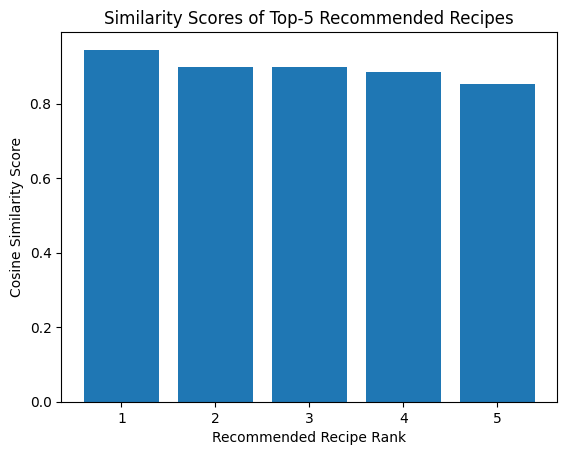

In [5]:
import matplotlib.pyplot as plt
user_input = "flour, sugar, milk, butter"
user_vector = vectorizer.transform([user_input])
distances, indices = model.kneighbors(user_vector, n_neighbors=5)

similarities = 1 - distances[0]

plt.figure()
plt.bar(range(1, 6), similarities)
plt.xlabel("Recommended Recipe Rank")
plt.ylabel("Cosine Similarity Score")
plt.title("Similarity Scores of Top-5 Recommended Recipes")
plt.show()


In [11]:
avg_sim = average_similarity("flour, sugar, milk, butter")
print("Average Similarity Score:", round(avg_sim, 3))

Average Similarity Score: 0.896
